In [ ]:
#importing libreries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from IPython.display import clear_output
from time import sleep
from dataprep.eda import create_report

##Importing dataset from kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download 'austinreese/craigslist-carstrucks-data' -f 'vehicles.csv'
!unzip vehicles.csv.zip

100% 262M/262M [00:08<00:00, 37.0MB/s]
100% 262M/262M [00:08<00:00, 34.1MB/s]
Archive:  vehicles.csv.zip
  inflating: vehicles.csv            


##Dataframe creation and filtering



In [ ]:
#Creating the dataframe
df = pd.read_csv('/content/vehicles.csv')

#Filtering de data by japanese manufacturer
df = df.loc[df['manufacturer'].isin(['mazda', 'toyota', 'nissan', 'honda',
                                     'lexus', 'infiniti', 'subaru', 'acura',
                                     'mitsubishi', 'datsun'])]

##Data Cleaning

###Defining functions.

In [ ]:
def col_splitter(df, col_name, split_point):
  """
      This function splits a column using a given
      splitting point and replaces it in the selected
      column.

      Parameters:
           df: Data frame selected.
           col_name: Columns to be dropped.
           split_point: Where the value should be splitted.
  """
  df[col_name] = df[col_name].str.split(split_point).map(lambda x: x[0])

In [ ]:
def target_encoder(df, indicator, target):
  """
     This function is designed to fill missing values in the specified target
     column based on the mode (most frequent value) of non-missing values for
     corresponding groups defined by a given indicator column in a DataFrame.

     Parameters:
        df: The input DataFrame containing the data.

        indicator: The name of the column used to define groups.

        target: The name of the column for which missing values will be
                imputed based on the mode of non-missing values within
                each group.
  """
  for col in target:
    #Cycling throug the values cointaned in the target column.
    for val in list(df[indicator].unique())[:]:
      #Creating a mask of non missing values contained in the tarrget column
      #Based on the indicator
      mask_stat = ((df.loc[:, col] == val) & (~df.loc[:,col].isna()))

      if not df.loc[mask_stat, col].empty:
        #Creating a mask of missing values contained in the tarrget column
        #Based on the indicator
        mask_miss_val = ((df.loc[:, indicator] == val) & (df.loc[:,col].isna()))

        #creating a vew of the dataframe with  missing values and filling them
        #the selected statistic
        df.loc[mask_miss_val, col] = df.loc[mask_stat, col].mode()[0]

###Start of cleaning process


In [ ]:
#Droping meaningless columns
df.drop(columns= ['id', 'url', 'region_url', 'image_url',
        'county', 'lat', 'long', 'VIN', 'description'], inplace= True)


<ipython-input-8-13f010f128a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns= ['id', 'url', 'region_url', 'image_url',


In [ ]:
df = df.loc[df['price']>0]

In [ ]:
#Dropping NaN values
df.dropna(subset= ['model', 'odometer'], inplace= True)

#Filtering excluding 10, 5 and other cylinder
df = df.loc[~df['cylinders'].isin(['10 cylinders', '5 cylinders','other'])]

In [ ]:
#Dropping duplicated rows
df.drop_duplicates(inplace= True)

#Reseting the index
df.reset_index(inplace= True)
df.drop(columns= 'index', inplace= True)

In [ ]:
#Filling categorical NaN values
df[['title_status', 'condition', 'paint_color']] = df.loc[:,['title_status',
                                                             'condition',
                                                             'paint_color']]\
                                                             .fillna(
                                                                 'unspecified'
                                                                 )

In [ ]:
#Standarizing categorical columns
standardizer = lambda DF, column_name: df[column_name].str.replace('\W', ' ',
                                                                  regex= True)\
               .str.lower()

for column in list(df.select_dtypes('object').columns):
  df[column] = standardizer(df, column)

In [ ]:
#Changing to ri and dc to it's correct state

df.loc[df['state'] == 'ri', 'state'] = 'ma'
df.loc[df['state'] == 'dc', 'state'] = 'wa'

In [ ]:
#Getting the categorical columns names with missing values
miss_cat_col = list(df.select_dtypes('object')\
     .columns[df.select_dtypes('object')\
              .isnull().any()])

target_encoder(df, 'model', miss_cat_col)

In [ ]:
#Filling categorical columns with Unspecified
df[miss_cat_col] = df.loc[:, miss_cat_col].fillna('unspecified')

In [ ]:
#Splitting columns to create unique features

for selected_column in [['posting_date', 't'], ['cylinders', ' ']]:
  col_splitter(df, selected_column[0], selected_column[1])

In [ ]:
df.groupby('region').agg({'region':'count'}).mean()

region    254.377171
dtype: float64

###Fixing Typos

In [ ]:
#Fixing the type to date time
df['posting_date'] = pd.to_datetime(df['posting_date'])

for numeric_col in ['year', 'price', 'odometer']:
  df[numeric_col] = df[numeric_col].astype('int64')

##Eda

In [ ]:
#Grouping the data
car_per_day = df.groupby('posting_date').agg({'manufacturer':'count'})

#Converting the data in to a pivot table
cars_pub_by_maker = df.pivot_table(index= 'posting_date',
                                   columns= 'manufacturer',
                                   aggfunc= 'size')

#Getting the most popular car brands
market_share = cars_pub_by_maker.sum().sort_values(ascending= False)[:5]

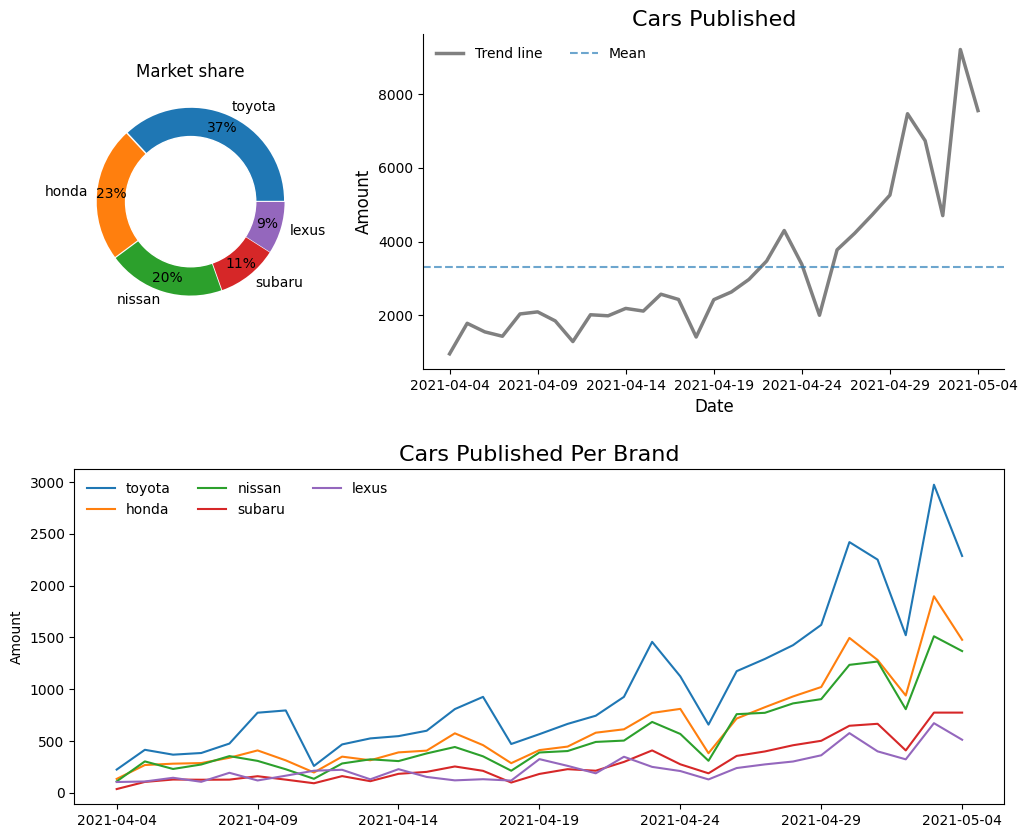

In [ ]:
fig = plt.figure(figsize= (12,10))

grid = GridSpec(2,3, fig)

#-------------------Creating the line chart-------------------
ax1 = fig.add_subplot(grid[0,1:])

ax1.set_title('Cars Published', fontsize= 16)

ax1.plot(car_per_day.index,
         car_per_day['manufacturer'],
         color= 'gray',
         linewidth= 2.5)

#Setting a line to indicate the mean postings
ax1.axhline(int(car_per_day.mean()), ls= '--', alpha= .65)

#Plotting the legend
ax1.legend(['Trend line', 'Mean'], ncols= 2, frameon= False)

#Formating axis
ax1.set_ylabel('Amount',fontsize= 12)
ax1.set_xlabel('Date',fontsize= 12)
ax1.set_xticks(car_per_day.index[::5])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

#-------------------Creating the donut chart-------------------
ax2 = fig.add_subplot(grid[0, 0:1])

ax2.set_title('Market share')

ax2.pie(market_share,
        autopct= '%0.f%%',
        labels= market_share.index,
        textprops= {'fontsize' : 10,},
        pctdistance= 0.85,
        explode= (0.01,0.01,0.01,0.01,0.01))

#Creating and plotting the hole
donut_hole = plt.Circle((0,0), 0.7, color= 'white')
fig = plt.gcf()

fig.gca().add_artist(donut_hole)

#-------------------Creating the line chart-------------------
ax3 = fig.add_subplot(grid[1,:])

ax3.set_title('Cars Published Per Brand', fontsize= 16)

#Creating a line per manufacturer
for maker in market_share.index:
  ax3.plot(cars_pub_by_maker.loc[:,maker].index,
          cars_pub_by_maker.loc[:,maker])

#Creating and plotting the label
ax3.legend(market_share.index,
           ncols = 3,
           frameon= False)

#Formating axis
ax3.set_ylabel('Amount')
ax3.set_xticks(cars_pub_by_maker.index[::5])

#Adjusting plot spaces
plt.subplots_adjust(wspace=0.5, hspace=0.3)

plt.show()

In [ ]:
filtered_data = df.loc[df['manufacturer'].isin(market_share.index)]

In [ ]:
filtered_data = filtered_data.loc[filtered_data['price'] < 135008900]

In [ ]:
#Finding the inter quartile range for the price and odometer variables
price_iqr = np.percentile(filtered_data['price'], 75) - \
            np.percentile(filtered_data['price'], 25)

odometer_iqr = np.percentile(filtered_data['odometer'], 75) - \
               np.percentile(filtered_data['odometer'],25)

#Setting the cutoff to filter outliers
prince_up = np.percentile(filtered_data['price'], 75) + 1.5 * price_iqr
odometer_up = np.percentile(filtered_data['odometer'],75) + 1.5* odometer_iqr

#Creating a mask to filter outliers
mask = ((filtered_data['price'] < prince_up) &
        (filtered_data['odometer'] < odometer_up))


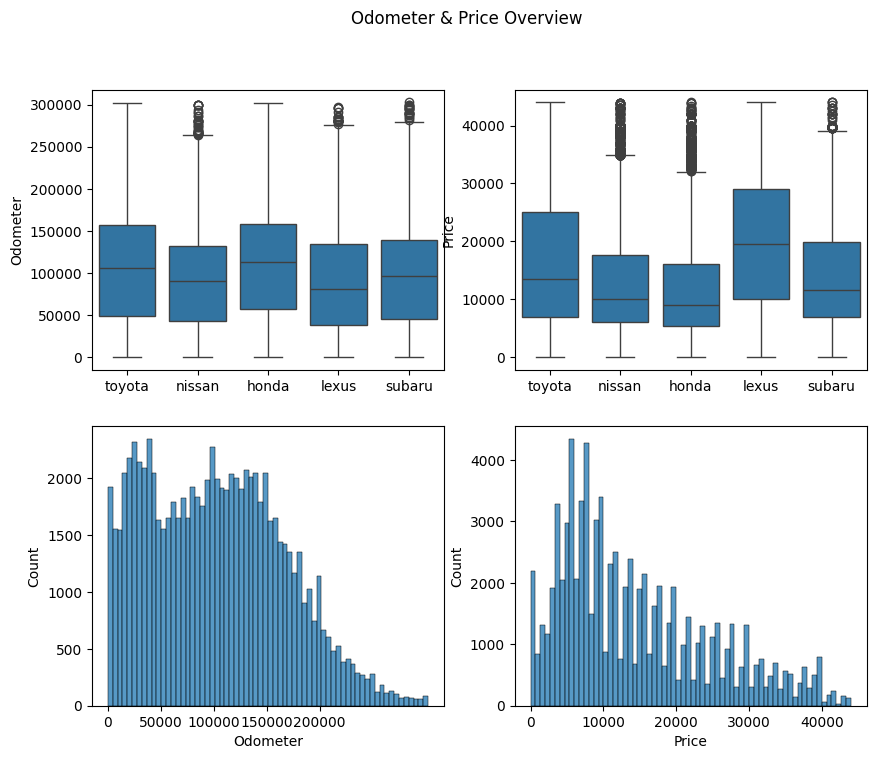

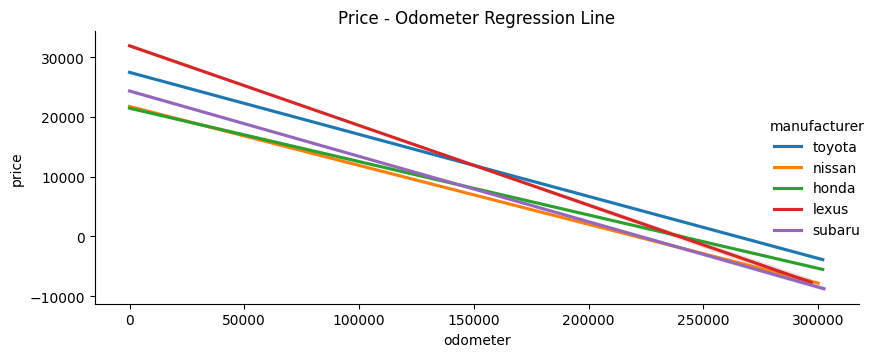

In [ ]:
fig = plt.figure(figsize=(10, 8))
grid = GridSpec(ncols=2, nrows=2, figure=fig)
fig.suptitle('Odometer & Price Overview')

# Creating the boxplot plots
ax1 = fig.add_subplot(grid[0, 0])
sns.boxplot(data=filtered_data[mask], x='manufacturer', y='odometer', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Odometer')

ax2 = fig.add_subplot(grid[0, 1])
sns.boxplot(data=filtered_data[mask], x='manufacturer', y='price', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Price')

# Creating the histograms
ax3 = fig.add_subplot(grid[1, 0])
sns.histplot(data=filtered_data[mask], x='odometer', ax=ax3)
ax3.set_xticks([50000 * i for i in range(5)])
ax3.set_xlabel('Odometer')
ax3.set_ylabel('Count')

ax4 = fig.add_subplot(grid[1, 1])
sns.histplot(data=filtered_data[mask], x='price', ax=ax4)
ax4.set_xlabel('Price')
ax4.set_ylabel('Count')

# Creating a regression line per manufacturer
sns.lmplot(
    data=filtered_data[mask],
    x='odometer',
    y='price',
    hue='manufacturer',
    height=4,
    aspect=1.932,
    scatter=False
)
plt.title('Price - Odometer Regression Line')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the suptitle position

plt.show()


Tengo que hacer que la data sea filtrada correctamente:

Hacer un sorteo para top 5 en avergae de price.   
Y verificar que la data se este leyendo correctamente.  

In [157]:
class CarReport():
  def __init__(self, data, manufacturer):
    self._data = data
    self._manufacturer = manufacturer

  def _mask_creator(self):
    """
      This function creates the mask to be used when filtering the data based
      in the user selection.

      returns:
              _top_model_mask: mask to filter the data by the top 5 models based
                               on the model selected.

              _model_mask: mask to filter the data by the selected
                                  model.

    """
    self._manufacturer_mask = self._data['manufacturer'] == self._manufacturer

    #Getting the top 5 models based on it's popularity
    self._models = self._data[self._manufacturer_mask].groupby('model')\
                  .agg({'price' : 'count'}).sort_values('price',
                                                       ascending = False)[:5]\
                  .index

    #Creating the mask

    self._top_model_mask = self._data['model'].isin(self._models)

    return self._top_model_mask, self._manufacturer_mask

  def _violin_plot(self, grid_space, mask):
    """
      This function creates a violin plot of the top five cars model of the
      selected car brand based in it's price. And returns the figure to the
      grid.
    """

    self.ax = self.fig.add_subplot(grid_space)

    #Creating the violin plot
    sns.violinplot(x= 'model', y= 'price',
                   data= self._data[mask],
                   ax = self.ax)

    #Setting the title
    plt.title(f'Top 5 {self._manufacturer} Models')

    self.ax.set_xlabel('')
    self.ax.tick_params(axis= 'x', rotation= 45)

  def _stacked_plot(self, grid_space, mask):
    """
      This function creates a 100% stacked bar plot. Where the bars represent
      the car condition and the subsets the title status.

      Input:
            grid_space: figure space where the chart is going to be despalyed.
            mask: mask that wants to be applied in the data
    """
    def trasform_data():
      """
        This function manipulates the data to create a pivot table and out of
        it calculate the porcentages of occurrance.
      """
      data = pd.pivot_table(self._data[mask], index= 'condition',
                            columns= 'title_status',values= 'drive' ,
                            aggfunc= 'count', fill_value= 0)

      return data.apply(lambda x: x * 100 / sum(x), axis=0)

    #Manipulating the data to get the right format
    self._porcentage = trasform_data()
    self.bottom = 0

    self.ax = self.fig.add_subplot(grid_space)

    #For each row in the table it'll create a bar
    for row in range(self._porcentage.shape[0]):
      self.ax.bar(self._porcentage.index, self._porcentage.iloc[row],
                  bottom= self.bottom)

      #Setting the bars bottoms
      self.bottom += self._porcentage.iloc[row]

    #Desambling the spines and setting up the x label
    self.ax.spines[['top', 'right']].set_visible(False)
    self.ax.set_xlabel('Car Condition')

    #Setting a title
    plt.title('Car Condition & Title Status')

    #Formating X axis
    self.ax.set_xticklabels(self._porcentage.index, rotation= 45)

    #Formating the label
    plt.legend(self._porcentage.columns, bbox_to_anchor= (1,1), frameon= False)

  def _pie_plot(self, grid_space, mask):
    """
      This function creates a donut chart that represent the distribution of the
      top 5 states based on the brand popularity.

      Inputs:
            grid_space: figure space where the chart is going to be despalyed.
            mask: mask that wants to be applied in the data
    """

    #Grouping the data
    self._states = self._data[mask].groupby('state').agg({'model' : 'count'})\
                    .sort_values('model', ascending = False)[:5]
    #Creating the piechart
    self.ax = self.fig.add_subplot(grid_space)

    plt.title('{} Top 5 States By Popularity'.format(self._manufacturer))

    self.ax.pie(self._states['model'],
                labels= self._states.index,
                autopct= '%0.0f%%',
                textprops= {'fontsize' : 10,},
                pctdistance= 0.85,
                explode= (0.01,0.01,0.01,0.01,0.01))

    #Creating the donut hole
    self.donut_hole = plt.Circle((0,0), 0.7, color= 'white')
    self.fig = plt.gcf()
    self.fig.gca().add_artist(self.donut_hole)

  def _bar_plot(self, grid_space, mask):
    """
      This function creates a barplot representing the popularity of the colors
      of the desired brand.

      Inputs:
            grid_space: figure space where the chart is going to be despalyed.
            mask: mask that wants to be applied in the data
    """
    #Grouping the data
    self._car_color = self._data[mask].groupby('paint_color')\
                      .agg({'type' : 'count'})

    #Creating the barplot
    self.ax = self.fig.add_subplot(grid_space)

    plt.title('Most Popular Colors')

    sns.barplot(x= self._car_color['type'],
                y= self._car_color.index,
                ax= self.ax)
    self.ax.set_xlabel('')

  def create_vizualization(self):
    """
      This function creates a report that shows a violin plot of top 5 models
      price, an stacked bar chart representing the car condition and title
      status, a donut chart that represent the distribution of the
      top 5 states based on the brand popularity and a bar plot of the colors
      popularity.
    """
    self._top_model_mask, self._model_mask = self._mask_creator()

    self.fig = plt.figure(figsize= (14,8))

    grid = GridSpec(2, 3,fig)

    self._violin_plot(grid[0,0], self._top_model_mask)

    self._stacked_plot(grid[0,1], self._model_mask)

    self._pie_plot(grid[1,0], self._model_mask)

    self._bar_plot(grid[1,1], self._model_mask)

    plt.tight_layout()

    plt.show()


In [158]:
cars = CarReport(df, 'toyota')

<ipython-input-157-5068cf0e2d80>:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(self._porcentage.index, rotation= 45)


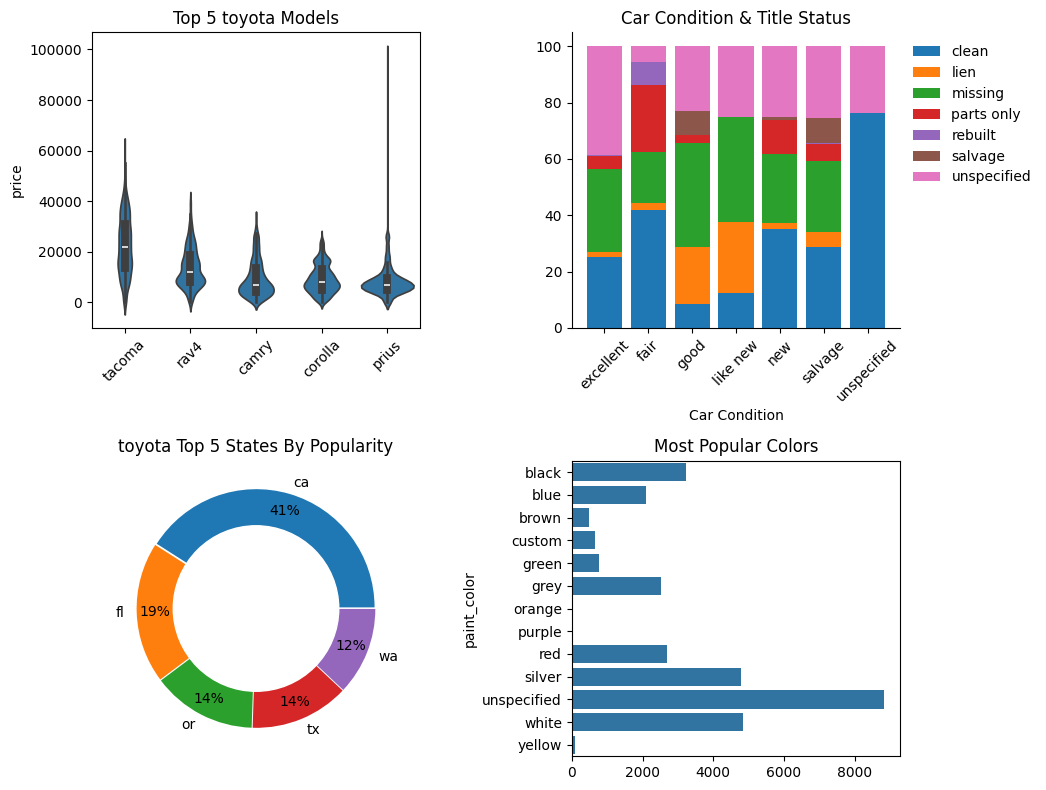

In [159]:
cars.create_vizualization()